# 심볼 탐지 테스트

> 쉬운 도면으로 테스트
1. 도면에서 심볼 탐지(data/symbol_mini.png를 도면에서 탐지)   
2. 심볼 기준으로 4분면 자르기

로드됨: symbol_mini
탐지된 심볼 수 (중복 제거 후): 1


/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: Us

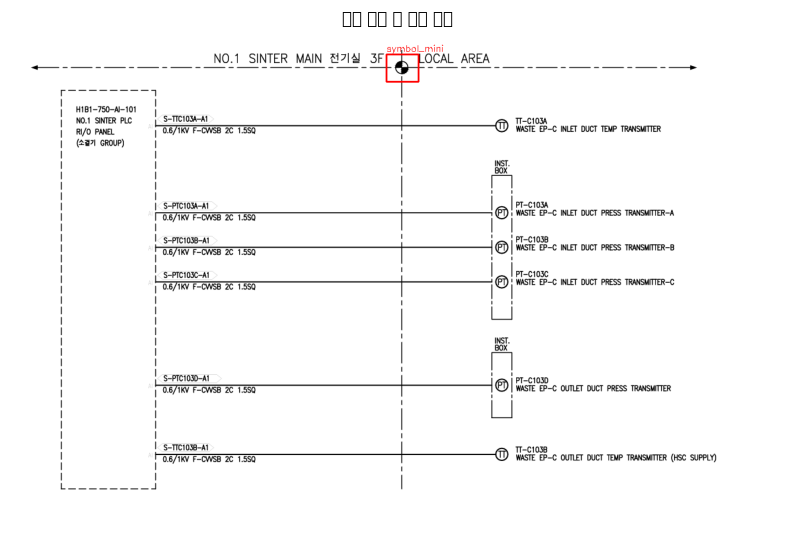

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, glob

def show_image(img, title="Image"):
    # 도면에 시각화하는 함수
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # Issue : detections 리스트에는 중복이 많음(비슷한 위치에 중복으로 잡히는 것 같음)
    # 중복 부분 제거하기 위한 작업
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        idxs = idxs[:-1]

        xx1 = np.maximum(x1[last], x1[idxs])
        yy1 = np.maximum(y1[last], y1[idxs])
        xx2 = np.minimum(x2[last], x2[idxs])
        yy2 = np.minimum(y2[last], y2[idxs])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs]

        idxs = idxs[overlap <= overlapThresh]

    return boxes[pick].astype(int)


# 테스트 도면
drawing_path = '../data/easy_task_test05_v1.PNG'
drawing = cv2.imread(drawing_path)
if drawing is None:
    raise FileNotFoundError(f"도면을 찾을 수 없습니다: {drawing_path}")
drawing_gray = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY)

# 심볼 이미지 로드
symbol_path = '../data/symbol_mini.PNG'
img = cv2.imread(symbol_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
name = os.path.splitext(os.path.basename(symbol_path))[0]
symbol = {"name": name, "gray": gray}
print(f"로드됨: {name}")

# 매칭 테스트
threshold = 0.75
res = cv2.matchTemplate(drawing_gray, symbol["gray"], cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= threshold)
h, w = symbol["gray"].shape

# 모든 탐지 좌표 수집
rectangles = []
for pt in zip(*loc[::-1]):
    rectangles.append([pt[0], pt[1], pt[0]+w, pt[1]+h])
    
filtered_boxes = non_max_suppression_fast(rectangles, overlapThresh=0.3)
print(f"탐지된 심볼 수 (중복 제거 후): {len(filtered_boxes)}")

result = drawing.copy()
for (x1, y1, x2, y2) in filtered_boxes:
    cv2.rectangle(result, (x1, y1), (x2, y2), (0,0,255), 2)
    cv2.putText(result, symbol["name"], (x1, y1-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

show_image(result, "중복 제거 후 탐지 결과")

#### 심볼 탐지 완료

> 심볼 위치 기준으로 주변 영역(선)을 따라 도면을 자르고 확대

/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48380 (\N{HANGUL SYLLABLE BOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


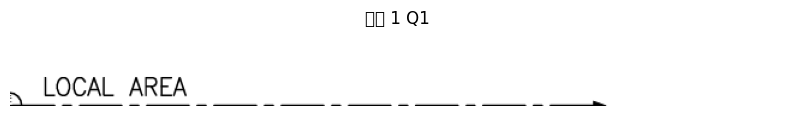

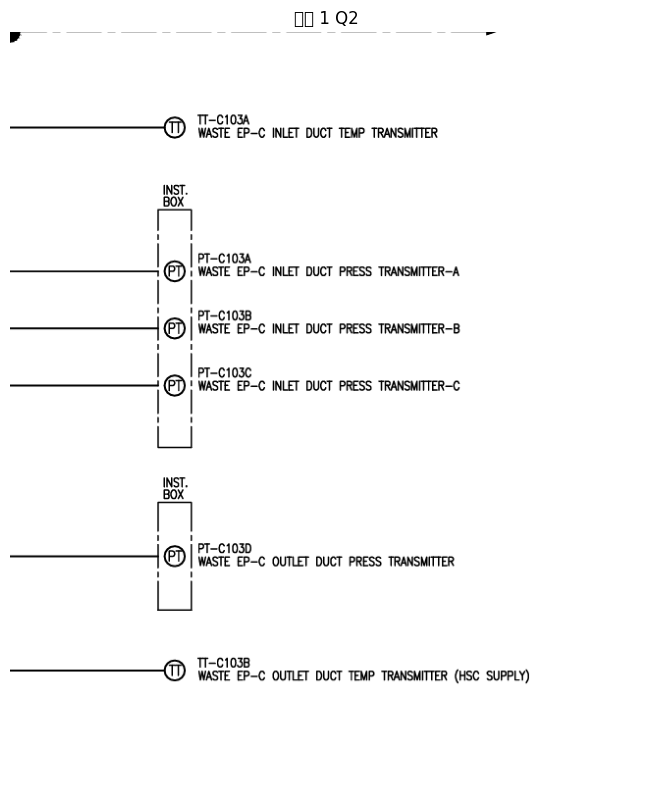

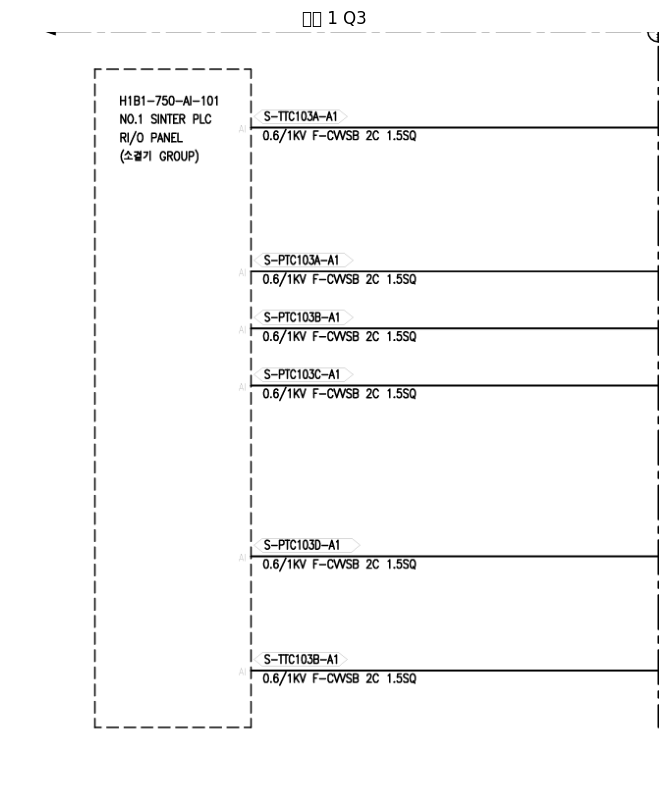

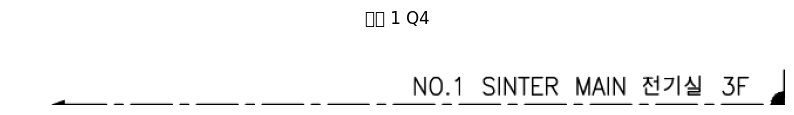

In [2]:
# 1. 엣지 검출
edges = cv2.Canny(drawing_gray, 50, 150)

# 2. HoughLinesP로 직선 검출
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

# 3. 수평선, 수직선 분류
h_lines = []  # (y, x_start, x_end)
v_lines = []  # (x, y_start, y_end)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 5:  # 수평선
            h_lines.append((y1, min(x1, x2), max(x1, x2)))
        elif abs(x2 - x1) < 5:  # 수직선
            v_lines.append((x1, min(y1, y2), max(y1, y2)))

# 4. fallback 영역 (선 없을 때 최소 ROI 크기)
fallback = 50
height, width = drawing.shape[:2]

# 5. 심볼 기준 4분면 ROI 추출 및 시각화
for idx, (sx1, sy1, sx2, sy2) in enumerate(filtered_boxes):
    cx = (sx1 + sx2)//2
    cy = (sy1 + sy2)//2

    # -----------------------------
    # 4분면 좌표 계산
    # Q1: 우상, Q2: 우하, Q3: 좌하, Q4: 좌상
    quadrants = [
        ("Q1", (0, cx, cy, width)),        # 우상
        ("Q2", (cy, cx, height, width)),   # 우하
        ("Q3", (cy, 0, height, cx)),       # 좌하
        ("Q4", (0, 0, cy, cx))             # 좌상
    ]

    for qname, (y1, x1, y2, x2) in quadrants:
        # fallback 적용 (ROI 최소 크기 확보)
        if (y2 - y1) < 1:
            y2 = min(height, y1 + fallback)
        if (x2 - x1) < 1:
            x2 = min(width, x1 + fallback)

        # ROI 추출
        roi = drawing[y1:y2, x1:x2]
        if roi.size == 0:
            print(f"심볼 {idx+1} {qname} ROI가 비어있음, 스킵")
            continue

        # 시각화 (확대 없이)
        show_image(roi, f"심볼 {idx+1} {qname}")